In [1]:
%load_ext autoreload
%autoreload 2
from gn4pions.modules.nn_functions import * 

In [2]:
df = load_data(n_files=100)

100%|██████████| 100/100 [02:09<00:00,  1.30s/it]


Dataframe has 1,027,650 events.


/clusterfs/ml4hep/mpettee/miniconda3/envs/nbdev/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [3]:
df.keys()

Index(['cluster_e_0', 'cluster_calib_e_0', 'cluster_had_weight_0', 'track_pt',
       'track_eta', 'track_phi', 'track_z0', 'truth_particle_e',
       'truth_particle_pt', 'log10_cluster_e_0', 'log10_cluster_calib_e_0',
       'log10_cluster_had_weight_0', 'log10_track_pt',
       'log10_truth_particle_e', 'log10_truth_particle_pt'],
      dtype='object')

In [4]:
# # recreate EM
# train_vars = ['log10_cluster_e_0',]
# target_var = ['log10_cluster_calib_e_0']

In [36]:
# # recreate track resolution
# train_vars = ['log10_track_pt', 
# #               'track_eta'
#              ]
# target_var = ['log10_truth_particle_pt']

In [69]:
train_vars = [
    'log10_cluster_e_0', 
    'log10_track_pt',
    'track_eta'
             ]
target_var = ['log10_truth_particle_e']

In [70]:
test = train(df, train_vars, target_var, epochs=20)

Epoch 1/20
19725/19725 [==============================] - 39s 2ms/step - loss: 0.0097 - val_loss: 0.0053
Epoch 2/20
19725/19725 [==============================] - 39s 2ms/step - loss: 0.0048 - val_loss: 0.0047
Epoch 3/20
19725/19725 [==============================] - 37s 2ms/step - loss: 0.0046 - val_loss: 0.0047
Epoch 4/20
19725/19725 [==============================] - 35s 2ms/step - loss: 0.0046 - val_loss: 0.0045
Epoch 5/20
19725/19725 [==============================] - 36s 2ms/step - loss: 0.0045 - val_loss: 0.0048
Epoch 6/20
19725/19725 [==============================] - 35s 2ms/step - loss: 0.0045 - val_loss: 0.0045
Epoch 7/20
19725/19725 [==============================] - 33s 2ms/step - loss: 0.0045 - val_loss: 0.0046
Epoch 8/20
19725/19725 [==============================] - 33s 2ms/step - loss: 0.0045 - val_loss: 0.0046
Epoch 9/20
19725/19725 [==============================] - 44s 2ms/step - loss: 0.0044 - val_loss: 0.0048
Epoch 10/20
19725/19725 [==============================

In [71]:
test[["nn_output", "nn_target"]]

,nn_output,nn_target
1,0.846417,0.844007
4,2.382642,2.367431
15,2.394368,2.372938
23,1.739094,1.743999
27,1.493983,1.498127
...,...,...
1027632,2.505790,2.502477
1027633,2.175623,2.184157
1027635,2.631917,2.587792
1027643,1.868833,1.864918


In [72]:
10**test.nn_output/(10**test.nn_target)

1          1.005565
4          1.035645
15         1.050584
23         0.988770
27         0.990505
             ...   
1027632    1.007657
1027633    0.980542
1027635    1.106942
1027643    1.009055
1027646    0.997216
Length: 197242, dtype: float32

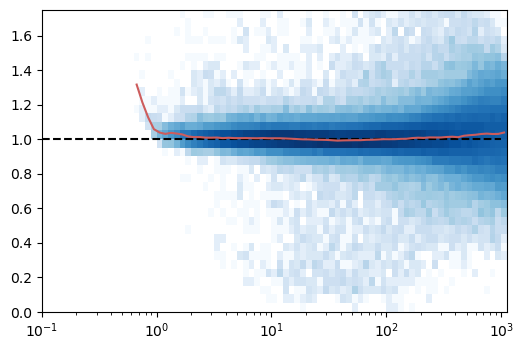

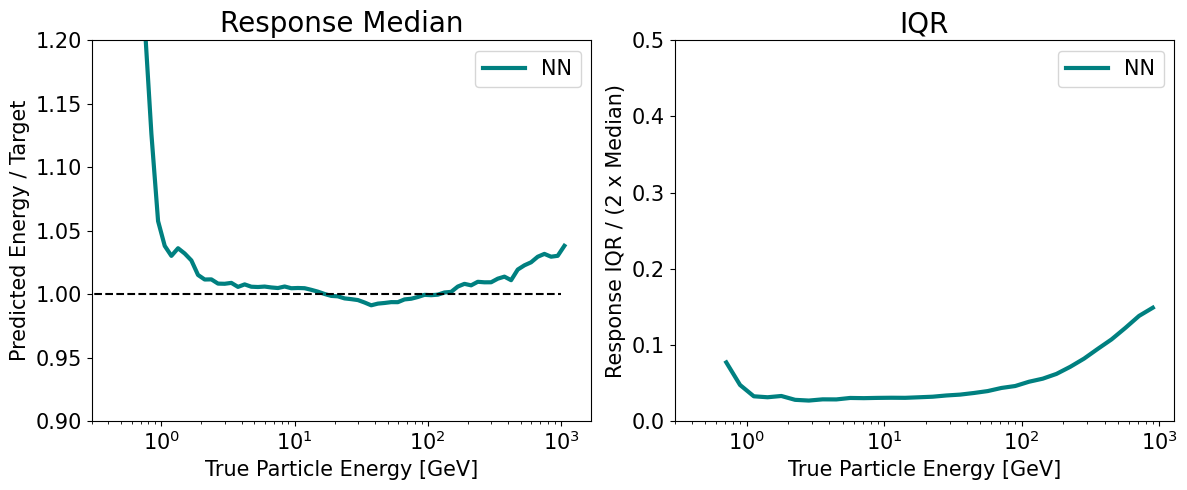

In [78]:
make_plots(test, plot_em=False, plot_track=False, 
#            save_label="dnn"
          )